## Import

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np
rng = np.random.default_rng(123456)

import librosa
import librosa.display
import IPython.display as ipd

from scipy.io import wavfile

import os
from sklearn import neighbors

## AudioDataset class

In [2]:
sliced_dataset = "short_audio_dataset"
sliced_dataset_lenght = 16050
# sliced_dataset = "shorter_audio_dataset"
# sliced_dataset_lenght = 4013
original_dataset = "audio_dataset"
original_dataset_lenght = 80249

class AudioDataset(Dataset):
    def __init__(self, root_path="./data/", drop_both=False, use_short=False, normalize=False, use_features=False):
        root_folder = root_path + original_dataset if not use_short else root_path + sliced_dataset
        self.use_features = use_features
        self.max_length = original_dataset_lenght if not use_short else sliced_dataset_lenght
        self.class_map = {"esben" : 0, "peter": 1, "both": 2}
        self.data = []
        self.wavs = []
        self.labels = []
        self.features_list = []
        self.min_val = 10e10
        self.max_val = 0
        print("Start reading files")
        for subdir, dirs, files in os.walk(root_folder):
            for file_name in files:
                if drop_both and "both" in subdir:
                   continue
        
                file_path = os.path.join(subdir, file_name)
                self.sample_rate, wav = wavfile.read(file_path)
                wav = wav.astype(np.float32)
                
                if wav.shape[0] > self.max_length:
                    self.max_length = wav.shape[0]
                    print("Found wav with more length than specified max one, new max is:", wav.shape[0])
                
                wav = np.pad(wav, (0, self.max_length-wav.shape[0]))
                features = np.transpose(self.feature_extraction(wav, self.sample_rate, normalize=normalize))
                label_str = file_path.split('/')[-3][2:]
                label = (np.int64(self.class_map[label_str]))
                
                self.max_val = np.max(wav) if np.max(wav) > self.max_val else self.max_val
                self.min_val = np.min(wav) if np.min(wav) < self.min_val else self.min_val
                
                self.wavs.append(wav)
                self.features_list.append(features)
                self.labels.append(label)
               
        self.wavs = np.array(self.wavs)
        self.mu  = self.wavs.mean()
        self.std = np.std(self.wavs)
        # self.wavs = torch.Tensor(self.wavs)
        if normalize:
            self.wavs = (self.wavs + np.abs(self.min_val)) / (np.abs(self.min_val) + self.max_val)
            # self.wavs = torch.nn.functional.normalize(self.wavs, dim=1)
        
        print("="*40)
        print("Loaded DATABASE from {}\n{} total file\nLongest file is {} long\nMean: {}\nStandard deviation: {}\nNormalization: {}".
              format(root_folder, len(self.wavs), self.max_length, self.mu, self.std, normalize))
        print("="*40)
    
    def feature_extraction(self, wav, sample_rate, n_mfcc=128, normalize=False):
        # extract features from the audio
        mfcc = np.mean(librosa.feature.mfcc(y=wav, sr=sample_rate, n_mfcc=n_mfcc).T, axis=0)
        if normalize:
            mfcc = (mfcc + np.abs(np.min(mfcc))) / (np.abs(np.min(mfcc)) + np.max(mfcc))
        return mfcc

    def __len__(self):
        return len(self.wavs)
    
    def __getitem__(self, idx):
        wav = self.wavs[idx]
        label = self.labels[idx]
        wav_tensor = torch.from_numpy(wav)
        label_tensor = torch.Tensor(label)
        if self.use_features:
            features = self.features_list[idx]
            features_tensor = torch.Tensor(features)
            return features_tensor, label_tensor
        return wav_tensor, label_tensor


## Loading data for training

In [3]:
audio_dataset = AudioDataset(root_path="../data/", drop_both=True, use_short=True, normalize=True, use_features=True)
dataset_len = len(audio_dataset)
train_size, test_size, valid_size = int(dataset_len * 0.7), int(dataset_len * 0.2), int(dataset_len * 0.1)

dataset_train, dataset_test, dataset_valid = torch.utils.data.random_split(audio_dataset, (train_size, test_size, valid_size))

kwargs = {'batch_size': 1, 'num_workers': 2}
loader_train = torch.utils.data.DataLoader(dataset_train, **kwargs, shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset_test, **kwargs, shuffle=True)
loader_valid = torch.utils.data.DataLoader(dataset_valid, **kwargs, shuffle=True)

Start reading files
Loaded DATABASE from ../data/short_audio_dataset
1000 total file
Longest file is 16050 long
Mean: -0.6988561153411865
Standard deviation: 2332.389404296875
Normalization: True


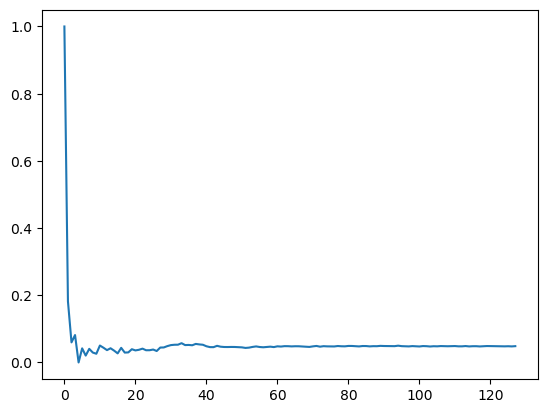

In [4]:
for x, _ in loader_train:
    plt.plot(np.arange(x.shape[1]), x.flatten())
    plt.show()
    break

## Autoencoder class

In [8]:
class AutoEncoder(nn.Module):
    def __init__(self, input_len):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_len, 256),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(256, input_len),
            nn.Sigmoid()
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)
        
    def forward(self, x):
        return self.decode(self.encode(x))

## Training autoencoder

In [9]:
model = AutoEncoder(audio_dataset.max_length)
opt = torch.optim.Adam(model.parameters())

for epoch in range(25):
    print(f'Epoch {epoch+1:02}/25', end=' ')
    for x, _ in loader_train:  
        x_rec = model(x) 
        loss = F.binary_cross_entropy(x_rec, x)
        
        opt.zero_grad()
        loss.backward()
        opt.step()

        mse = F.mse_loss(x_rec, x)
        mae = F.l1_loss(x_rec, x)
        
    print(f'loss: {loss.item():.4f} - rmse: {np.sqrt(mse.item()):.4f} - mae: {mae.item():.4f}')

Epoch 01/25 loss: 0.0816 - rmse: 0.0161 - mae: 0.0156
Epoch 02/25 loss: 0.1327 - rmse: 0.0061 - mae: 0.0038
Epoch 03/25 loss: 0.1059 - rmse: 0.0063 - mae: 0.0034
Epoch 04/25 loss: 0.1734 - rmse: 0.0060 - mae: 0.0034
Epoch 05/25 loss: 0.1040 - rmse: 0.0038 - mae: 0.0022
Epoch 06/25 loss: 0.1267 - rmse: 0.0055 - mae: 0.0031
Epoch 07/25 loss: 0.1623 - rmse: 0.0047 - mae: 0.0024
Epoch 08/25 loss: 0.1144 - rmse: 0.0079 - mae: 0.0045
Epoch 09/25 loss: 0.1545 - rmse: 0.0042 - mae: 0.0023
Epoch 10/25 loss: 0.0860 - rmse: 0.0050 - mae: 0.0028
Epoch 11/25 loss: 0.1462 - rmse: 0.0042 - mae: 0.0024
Epoch 12/25 loss: 0.1053 - rmse: 0.0054 - mae: 0.0034
Epoch 13/25 loss: 0.1040 - rmse: 0.0032 - mae: 0.0018
Epoch 14/25 loss: 0.1297 - rmse: 0.0045 - mae: 0.0022
Epoch 15/25 loss: 0.0843 - rmse: 0.0028 - mae: 0.0018
Epoch 16/25 loss: 0.1116 - rmse: 0.0040 - mae: 0.0022
Epoch 17/25 loss: 0.1223 - rmse: 0.0032 - mae: 0.0021
Epoch 18/25 loss: 0.1608 - rmse: 0.0053 - mae: 0.0031
Epoch 19/25 loss: 0.1356 - r

## Define knn function

In [ ]:
def knn_param_search(train_data, train_labels, test_data, test_labels, 
                     metrics=('manhattan', 'euclidean', 'chebyshev'), 
                     ks=(1, 3, 5, 10, 25, 50, 100, 250), 
                     n_train=None, n_test=None, algorithm='brute'):
  """
  Takes a dataset and plots knn classification accuracy 
  for different hyper parameters.

  n_train and n_test allows to subsample the dataset for faster iteration
  """
  x_train = np.array(train_data)
  y_train = np.array(train_labels)
  x_test = np.array(test_data)
  y_test = np.array(test_labels)
  
  # subsample the dataset
  if n_train:
    x_train, y_train = x_train[:n_train], y_train[:n_train]
  if n_test:
    x_test, y_test = x_test[:n_test], y_test[:n_test]

  for metric in metrics:
    print(f'Metric: {metric}', end=' ')
    for k in ks:
        print(f'k: {k}', end=' ')
        classifier = neighbors.KNeighborsClassifier(k, algorithm=algorithm, metric=metric)
        classifier = classifier.fit(x_train, y_train)

        labels = classifier.predict(x_test)
        
        correct = labels == np.array(y_test)
        print(f'Accuracy: {correct.mean() * 100:.2f} %', end=' ')

  return classifier

## Call KNN

In [ ]:
classifier = knn_param_search(dataset_train.dataset.wavs, 
                              dataset_train.dataset.labels, 
                              dataset_test.dataset.wavs, 
                              dataset_test.dataset.labels,
                              metrics=['euclidean'],
                              ks=[2]
                             )

Metric: euclidean k: 2 Accuracy: 79.80 % 

In [ ]:
predicted_labels = classifier.predict(dataset_valid.dataset.wavs)
correct = predicted_labels == np.array(dataset_valid.dataset.labels)
print(f' Accuracy: {correct.mean() * 100:.2f}')

 Accuracy: 79.80
